In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, plot_roc_curve, classification_report
from sklearn import model_selection

In [2]:
#Load Dataframes of the different component
rooth_path = '../data/'
generator_train = pd.read_csv(rooth_path + 'generator_train.csv')
gen_bear_train = pd.read_csv(rooth_path + 'gen_bear_train.csv')
transformer_train = pd.read_csv(rooth_path + 'transformer_train.csv')
hydraulic_train = pd.read_csv(rooth_path + 'hydraulic_train.csv')
gearbox_train = pd.read_csv(rooth_path + 'gearbox_train.csv')
generator_test = pd.read_csv(rooth_path + 'generator_test.csv')
gen_bear_test = pd.read_csv(rooth_path + 'gen_bear_test.csv')
transformer_test = pd.read_csv(rooth_path + 'transformer_test.csv')
hydraulic_test = pd.read_csv(rooth_path + 'hydraulic_test.csv')
gearbox_test = pd.read_csv(rooth_path + 'gearbox_test.csv')

### We are ready to build our base-model for each component. 

- We will need to scale the features, within each turbine
- Since we have a very unbalanced dataset we will use SMOTE for balancing the training data set
- Reach a base line model
- Try other algorithms and fine tune
- Probably we will need to change the threshold to reduce the FP
- Calculate the different costs of our best models

In [3]:
# Scale within each turbine
def scale (df_train, df_test, scaler='StandardScaler'):
    
    '''Scale within each given turbine
    
    Args:
            df_train      : Train datarame
            df_test       : Test dataframe
        
    Returns:
            array         : Scaled array of train and test'''
    
    
    # Scale for turbine T01 first
    X_train1 = df_train.loc[df_train['Turbine_ID']=='T01']
    X_test1 = df_test.loc[df_test['Turbine_ID']=='T01']

    X_train1 = X_train1.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])
    X_test1 = X_test1.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])
    
    if scaler == 'MinMaxScaler':
        sc = MinMaxScaler()
        X_train1 = sc.fit_transform(X_train1)
        X_test1 = sc.transform(X_test1) 
    else:
        sc = StandardScaler()
        X_train1 = sc.fit_transform(X_train1)
        X_test1 = sc.transform(X_test1) 
    
    # Scale on other turbines
    turbines = ['T06', 'T07', 'T09', 'T11']
    for turbine in turbines:
        X_train_ = df_train.loc[df_train['Turbine_ID']==turbine]
        X_test_ = df_test.loc[df_test['Turbine_ID']==turbine]

        X_train_ = X_train_.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])
        X_test_ = X_test_.drop(columns=['Turbine_ID', 'Date', 'TTF', 'Failure'])

        if scaler == 'MinMaxScaler':
            sc = MinMaxScaler()
            X_train_ = sc.fit_transform(X_train_)
            X_test_ = sc.transform(X_test_)
        else:
            sc = StandardScaler()
            X_train_ = sc.fit_transform(X_train_)
            X_test_ = sc.transform(X_test_)
        
        # Concatenate
        X_train1 = np.concatenate((X_train1, X_train_))
        X_test1 = np.concatenate((X_test1, X_test_))
        
             
    return X_train1, X_test1

In [4]:
# Data augmentation using SMOTE
def data_aug(X_train, y_train):
    
    '''Function for data augmentation, using SMOTE
    
    
    '''
    all_classes = Counter(y_train)
    majority_class = all_classes.most_common(1)
    minority_class = all_classes.most_common()[1:]
    ratio = minority_class[0][1]/majority_class[0][1]
    
    if ratio < 0.1:
        over = SMOTE(sampling_strategy=0.1, random_state=0) # 10% of positive examples
        X_train, y_train = over.fit_sample(X_train, y_train)    
    
    return X_train, y_train

In [5]:
# Function to predict
def bin_classify(model, clf, X_train, X_test, y_train, y_test, params=None, score=None, ):
    
    #Grid Search
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    train_pred = grid_search.predict(X_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
    
    #Predictions
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions

In [6]:
# Function for metrics
def metrics(estimator, X_test, y_test, y_pred):
    
    # Classification Report
    print(classification_report(y_test, y_pred))
    # Confusion MAtrix
    print(confusion_matrix(y_test, y_pred))
    
    #Plot Roc
    plot_roc_curve(estimator, X_test, y_test, name = f'{estimator}')

In [7]:
# Logistic Regression
def logreg(X_train, X_test, y_train, y_test):
    model = 'Logistic Regression'
    clf_logreg = LogisticRegression(random_state=42, max_iter=3000, n_jobs=-1)
    gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
    gs_score = 'roc_auc'

    clf_logreg, pred_logreg = bin_classify(model, clf_logreg, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_logreg)
    
    metrics(clf_logreg, X_test, y_test, pred_logreg['y_pred'])
    
    return clf_logreg, pred_logreg

In [8]:
# Random Forest Classifier
def rfc(X_train, X_test, y_train, y_test):
    model = 'Random Forest Classifier'
    clf_rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
    gs_params = {'n_estimators': [10, 20, 50, 100], 'max_depth': [4, 5, 6, 7, 8, 10, 15, 20], 'criterion': ['gini', 'entropy']}
    gs_score = 'roc_auc'

    clf_rfc, pred_rfc = bin_classify(model, clf_rfc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_rfc)
    
    metrics(clf_rfc, X_test, y_test, pred_rfc['y_pred'])
    
    return clf_rfc, pred_rfc

In [9]:
# Gradient Boosting Classifier
def gbc(X_train, X_test, y_train, y_test):
    model = 'Gradient Boosting Classifier'
    clf_gbc = GradientBoostingClassifier(random_state=42)
    gs_params = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [0.1, 0.5, 0.6, 0.8, 1, 1.01]}
    gs_score = 'roc_auc'

    clf_gbc, pred_gbc= bin_classify(model, clf_gbc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_gbc)

    metrics(clf_gbc, X_test, y_test, pred_gbc['y_pred'])
    
    return clf_gbc, pred_gbc

In [10]:
# K-Neighbors
def knn(X_train, X_test, y_train, y_test):
    model = 'KNN'
    clf_knn = KNeighborsClassifier(n_jobs=-1)
    gs_params = {'n_neighbors': [5, 7, 10, 15]}
    gs_score = 'roc_auc'

    clf_knn, pred_knn= bin_classify(model, clf_knn, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_knn)

    metrics(clf_knn, X_test, y_test, pred_knn['y_pred'])
    
    return clf_knn, pred_knn

In [11]:
# Ada Boost Classifier
def abc(X_train, X_test, y_train, y_test):
    model = 'AdaBoostClassifier'
    clf_abc = AdaBoostClassifier(random_state=42)
    gs_params = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]}
    gs_score = 'roc_auc'

    clf_abc, pred_abc= bin_classify(model, clf_abc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_abc)

    metrics(clf_abc, X_test, y_test, pred_abc['y_pred'])
    
    return clf_abc, pred_abc

In [12]:
# SVC
def svc(X_train, X_test, y_train, y_test):
    model = 'SVC'
    clf_svc = SVC(random_state=42)
    gs_params = {'C': [0.01, 0.1, 1, 1.2], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2,3], 'gamma': ['auto', 'scale']}
    gs_score = 'roc_auc'

    clf_svc, pred_svc= bin_classify(model, clf_svc, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_svc)

    metrics(clf_svc, X_test, y_test, pred_svc['y_pred'])
    
    return clf_svc, pred_svc

In [13]:
# Naive Bayes
def gnb(X_train, X_test, y_train, y_test):
    model = 'Gaussian NB'
    clf_gnb = GaussianNB()
    gs_params = {}
    gs_score = 'roc_auc'

    clf_gnb, pred_gnb= bin_classify(model, clf_gnb, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
    print('\nBest Parameters:\n',clf_gnb)

    metrics(clf_gnb, X_test, y_test, pred_gnb['y_pred'])
    
    return clf_gnb, pred_gnb

# GENERATOR

In [14]:
# By exploration, drop columns:
gen_col_drop = ['Gen_RPM_Min', 'Gen_RPM_Min_av', 'Gen_RPM_Min_sd', 'Gen_RPM_Avg', 'Gen_RPM_Avg_av', 'Gen_RPM_Avg_sd',
                'Gen_Phase1_Temp_Avg', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase1_Temp_Avg_sd',
                'Gen_Phase3_Temp_Avg', 'Gen_Phase3_Temp_Avg_av', 'Gen_Phase3_Temp_Avg_sd',
                'Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd',
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd',
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd',
                'Amb_WindSpeed_Std', 'Amb_WindSpeed_Std_av', 'Amb_WindSpeed_Std_sd',
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd',
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                'Nac_Temp_Avg', 'Nac_Temp_Avg_av', 'Nac_Temp_Avg_sd',
                'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [15]:
# Drop columns
generator_train = generator_train.drop(columns = gen_col_drop)
generator_test = generator_test.drop(columns = gen_col_drop)

In [16]:
# Scale
X_train_gen, X_test_gen = scale(generator_train, generator_test)

In [17]:
# Define target and Data Augmentation on training data
y_train_gen = generator_train['Failure']
y_test_gen = generator_test['Failure']
X_train_gen, y_train_gen = data_aug(X_train_gen, y_train_gen)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.85      1220
   macro avg       0.47      0.45      0.46      1220
weighted avg       0.90      0.85      0.88      1220

[[1042  119]
 [  59    0]]

Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=50,
                       n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1161    0]
 [  59    0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 GradientBoostingClassifier(learning_rate=1.01, random_state=42)
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1161
           1       0.49      0.90      0.63        59

    accuracy                           0.95      1220
   macro avg       0.74      0.93      0.80      1220
weighted avg       0.97      0.95      0.96      1220

[[1106   55]
 [   6   53]]

Best Parameters:
 KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.86      1220
   macro avg       0.47      0.45      0.46      1220
weighted avg       0.90      0.86      0.88      1220

[[1054  107]
 [  59    0]]

Best Parameters:
 AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           

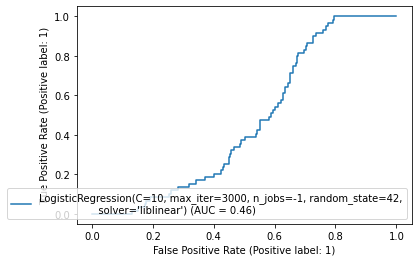

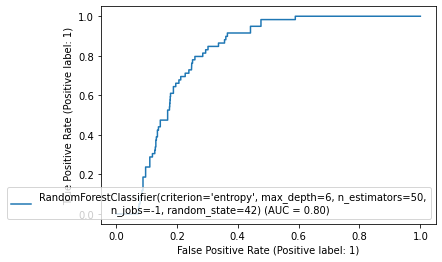

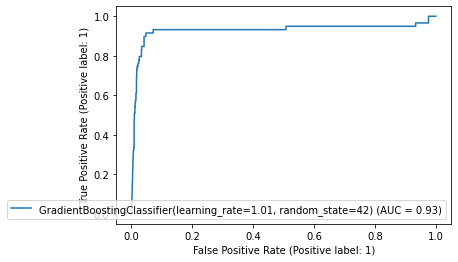

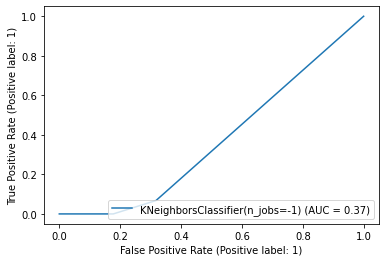

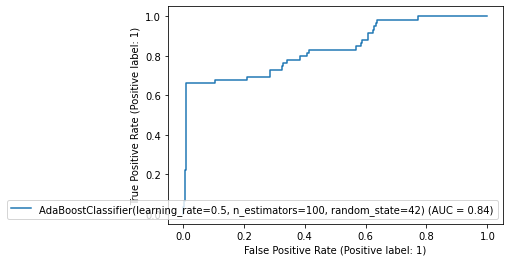

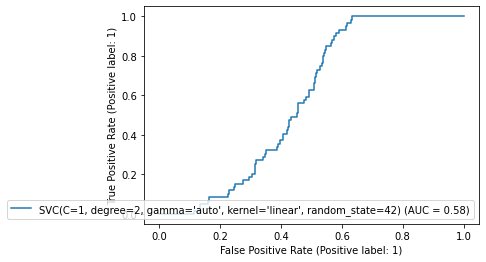

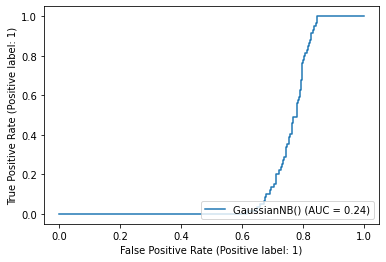

In [18]:
clf_logreg_gen, pred_logreg_gen = logreg(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_rfc_gen, pred_rfc_gen = rfc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_gbc_gen, pred_gbc_gen = gbc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_knn_gen, pred_knn_gen = knn(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_abc_gen, pred_abc_gen = abc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_svc_gen, pred_svc_gen = svc(X_train_gen, X_test_gen, y_train_gen, y_test_gen)
clf_gnb_gen, pred_gnb_gen = gnb(X_train_gen, X_test_gen, y_train_gen, y_test_gen)

# GENERATOR BEARING

In [19]:
# By exploration, drop columns:
bear_col_drop = ['Gen_RPM_Min', 'Gen_RPM_Min_av', 'Gen_RPM_Min_sd', 'Gen_RPM_Avg', 'Gen_RPM_Avg_av', 'Gen_RPM_Avg_sd',
                'Gen_Phase1_Temp_Avg', 'Gen_Phase1_Temp_Avg_av', 'Gen_Phase1_Temp_Avg_sd',
                'Gen_Phase3_Temp_Avg', 'Gen_Phase3_Temp_Avg_av', 'Gen_Phase3_Temp_Avg_sd',
                'Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd',
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd',
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd',
                'Amb_WindSpeed_Std', 'Amb_WindSpeed_Std_av', 'Amb_WindSpeed_Std_sd',
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd',
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                'Nac_Temp_Avg', 'Nac_Temp_Avg_av', 'Nac_Temp_Avg_sd',
                'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [20]:
# Drop columns
gen_bear_train = gen_bear_train.drop(columns = bear_col_drop)
gen_bear_test = gen_bear_test.drop(columns = bear_col_drop)

In [21]:
# Scale
X_train_bear, X_test_bear = scale(gen_bear_train, gen_bear_test)

In [22]:
# Define target and Data Augmentation on training data
y_train_bear = gen_bear_train['Failure']
y_test_bear = gen_bear_test['Failure']
X_train_bear, y_train_bear = data_aug(X_train_bear, y_train_bear)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.90      0.62      0.74      1138
           1       0.02      0.09      0.03        82

    accuracy                           0.59      1220
   macro avg       0.46      0.35      0.38      1220
weighted avg       0.84      0.59      0.69      1220

[[710 428]
 [ 75   7]]

Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=20,
                       n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1138
           1       0.40      0.02      0.05        82

    accuracy                           0.93      1220
   macro avg       0.67      0.51      0.51      1220
weighted avg       0.90      0.93      0.90      1220

[[1135    3]
 [  80    2]]

Best Parameters:
 Gradien

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

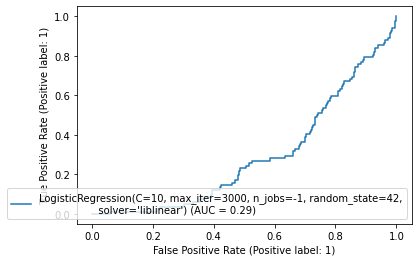

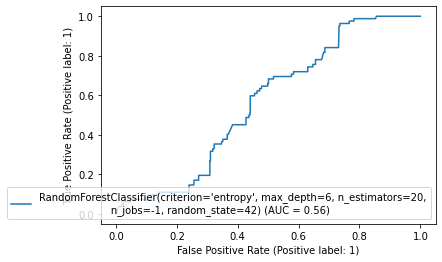

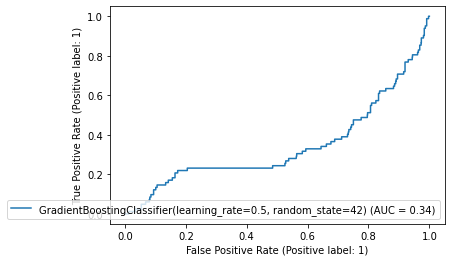

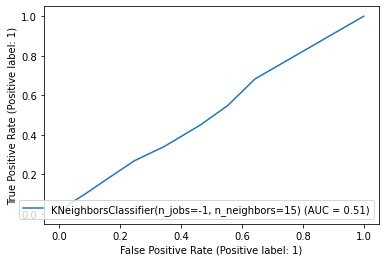

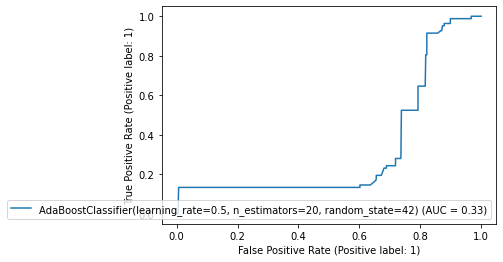

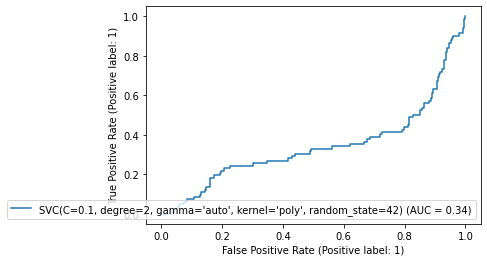

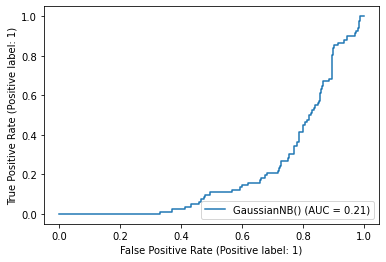

In [23]:
clf_logreg_bear, pred_logreg_bear = logreg(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_rfc_bear, pred_rfc_bear = rfc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_gbc_bear, pred_gbc_bear = gbc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_knn_bear, pred_knn_bear = knn(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_abc_bear, pred_abc_bear = abc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_svc_bear, pred_svc_bear = svc(X_train_bear, X_test_bear, y_train_bear, y_test_bear)
clf_gnb_bear, pred_gnb_bear = gnb(X_train_bear, X_test_bear, y_train_bear, y_test_bear)

# TRANSFORMER

In [24]:
# By exploration, drop columns:
transf_col_drop = ['HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg_av', 'HVTrafo_Phase2_Temp_Avg_sd',
                   'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase1_Temp_Avg_av', 'HVTrafo_Phase1_Temp_Avg_sd',
                   'Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd',
                   'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd',
                   'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd',
                   'Amb_WindSpeed_Std', 'Amb_WindSpeed_Std_av', 'Amb_WindSpeed_Std_sd',
                   'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd',
                   'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                   'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [25]:
# Drop columns
transformer_train = transformer_train.drop(columns = transf_col_drop)
transformer_test = transformer_test.drop(columns = transf_col_drop)

In [26]:
# Scale
X_train_transf, X_test_transf = scale(transformer_train, transformer_test)

In [28]:
# Define target and Data Augmentation on training data
y_train_transf = transformer_train['Failure']
y_test_transf = transformer_test['Failure']
X_train_transf, y_train_transf = data_aug(X_train_transf, y_train_transf)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      1161
           1       0.15      0.53      0.23        59

    accuracy                           0.83      1220
   macro avg       0.56      0.69      0.57      1220
weighted avg       0.93      0.83      0.87      1220

[[982 179]
 [ 28  31]]

Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50,
                       n_jobs=-1, random_state=42)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1161
           1       0.00      0.00      0.00        59

    accuracy                           0.95      1220
   macro avg       0.48      0.50      0.49      1220
weighted avg       0.91      0.95      0.93      1220

[[1159    2]
 [  59    0]]

Best Parameters:
 GradientBoos

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

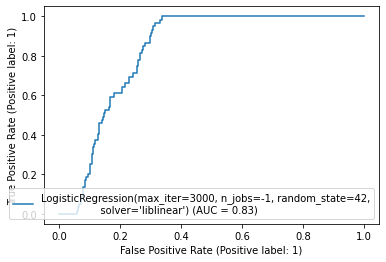

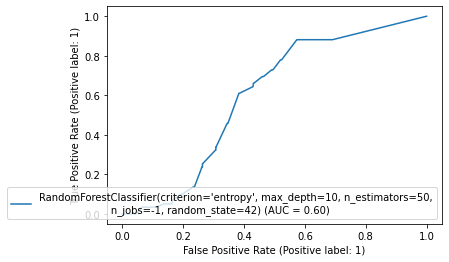

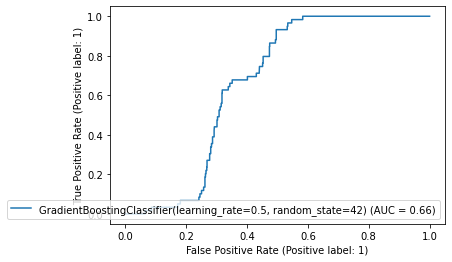

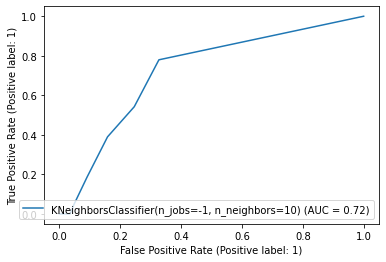

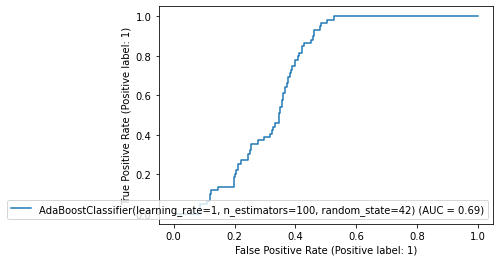

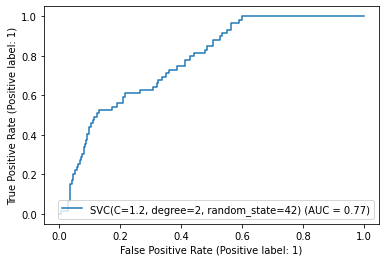

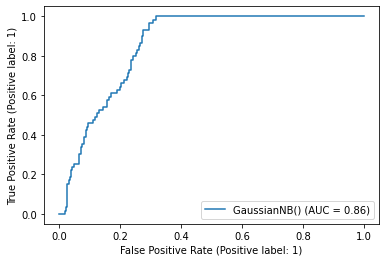

In [29]:
clf_logreg_transf, pred_logreg_transf = logreg(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_rfc_transf, pred_rfc_transf = rfc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_gbc_transf, pred_gbc_transf = gbc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_knn_transf, pred_knn_transf = knn(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_abc_transf, pred_abc_transf = abc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_svc_transf, pred_svc_transf = svc(X_train_transf, X_test_transf, y_train_transf, y_test_transf)
clf_gnb_transf, pred_gnb_transf = gnb(X_train_transf, X_test_transf, y_train_transf, y_test_transf)

# HYDRAULIC

In [30]:
# By exploration, drop columns:
hyd_col_drop = ['Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd',
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd',
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd',
                'Amb_WindSpeed_Min', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Min_sd',
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd',
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [31]:
# Drop columns
hydraulic_train = hydraulic_train.drop(columns = hyd_col_drop)
hydraulic_test = hydraulic_test.drop(columns = hyd_col_drop)

In [32]:
# Scale
X_train_hyd, X_test_hyd = scale(hydraulic_train, hydraulic_test)

In [33]:
# Define target and Data Augmentation on training data
y_train_hyd = hydraulic_train['Failure']
y_test_hyd = hydraulic_test['Failure']
X_train_hyd, y_train_hyd = data_aug(X_train_hyd, y_train_hyd)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1043
           1       0.26      0.19      0.22       177

    accuracy                           0.80      1220
   macro avg       0.56      0.55      0.55      1220
weighted avg       0.78      0.80      0.79      1220

[[945  98]
 [143  34]]

Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=15, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1043
           1       0.00      0.00      0.00       177

    accuracy                           0.85      1220
   macro avg       0.43      0.50      0.46      1220
weighted avg       0.73      0.85      0.79      1220

[[1043    0]
 [ 177    0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,


Best Parameters:
 GradientBoostingClassifier(learning_rate=0.5, random_state=42)
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1043
           1       0.56      0.13      0.21       177

    accuracy                           0.86      1220
   macro avg       0.72      0.56      0.57      1220
weighted avg       0.82      0.86      0.82      1220

[[1025   18]
 [ 154   23]]

Best Parameters:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=7)
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1043
           1       0.13      0.15      0.14       177

    accuracy                           0.73      1220
   macro avg       0.49      0.49      0.49      1220
weighted avg       0.75      0.73      0.74      1220

[[869 174]
 [151  26]]

Best Parameters:
 AdaBoostClassifier(learning_rate=1, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

   

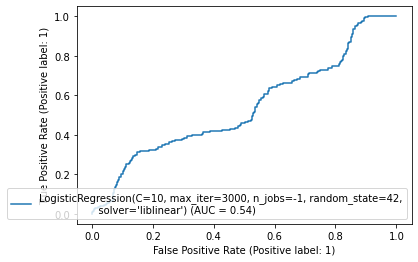

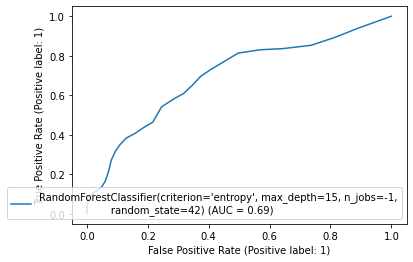

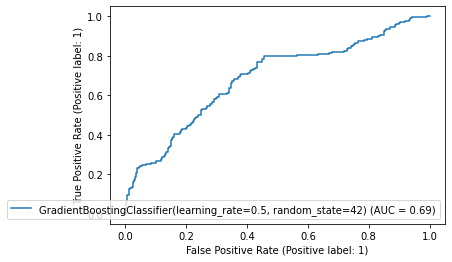

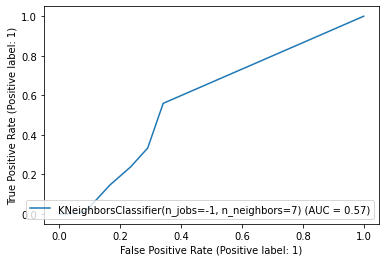

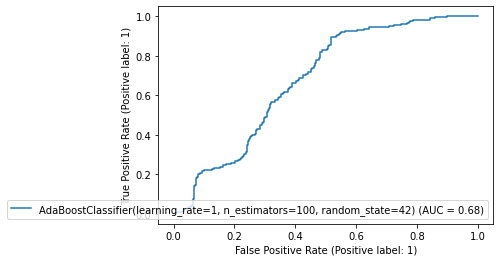

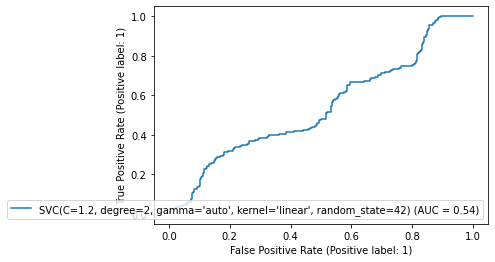

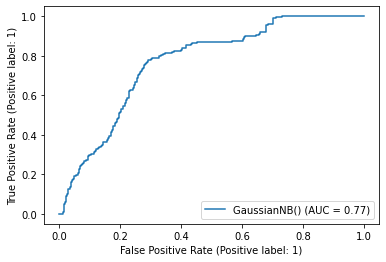

In [34]:
clf_logreg_hyd, pred_logreg_hyd = logreg(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_rfc_hyd, pred_rfc_hyd = rfc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_gbc_hyd, pred_gbc_hyd = gbc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_knn_hyd, pred_knn_hyd = knn(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_abc_hyd, pred_abc_hyd = abc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_svc_hyd, pred_svc_hyd = svc(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)
clf_gnb_hyd, pred_gnb_hyd = gnb(X_train_hyd, X_test_hyd, y_train_hyd, y_test_hyd)

# GEARBOX

In [35]:
# By exploration, drop columns:
gear_col_drop = ['Blds_PitchAngle_Min', 'Blds_PitchAngle_Min_av', 'Blds_PitchAngle_Min_sd',
                'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Avg_av', 'Blds_PitchAngle_Avg_sd',
                'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg_av', 'Amb_WindSpeed_Avg_sd',
                'Amb_WindSpeed_Min', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Min_sd',
                'Cont_Top_Temp_Avg', 'Cont_Top_Temp_Avg_av', 'Cont_Top_Temp_Avg_sd',
                'Cont_VCP_Temp_Avg', 'Cont_VCP_Temp_Avg_av', 'Cont_VCP_Temp_Avg_sd',
                'Grd_Busbar_Temp_Avg', 'Grd_Busbar_Temp_Avg_av', 'Grd_Busbar_Temp_Avg_sd']

In [36]:
# Drop columns
gearbox_train = gearbox_train.drop(columns = gear_col_drop)
gearbox_test = gearbox_test.drop(columns = gear_col_drop)

In [37]:
# Scale
X_train_gear, X_test_gear = scale(gearbox_train, gearbox_test)

In [38]:
# Define target and Data Augmentation on training data
y_train_gear = gearbox_train['Failure']
y_test_gear = gearbox_test['Failure']
X_train_gear, y_train_gear = data_aug(X_train_gear, y_train_gear)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metr


Best Parameters:
 LogisticRegression(C=10, max_iter=3000, n_jobs=-1, random_state=42,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1220
           1       0.00      0.00      0.00         0

    accuracy                           0.93      1220
   macro avg       0.50      0.47      0.48      1220
weighted avg       1.00      0.93      0.96      1220

[[1135   85]
 [   0    0]]

Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=15, n_jobs=-1,
                       random_state=42)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1220

    accuracy                           1.00      1220
   macro avg       1.00      1.00      1.00      1220
weighted avg       1.00      1.00      1.00      1220

[[1220]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)



Best Parameters:
 GradientBoostingClassifier(learning_rate=0.8, random_state=42)
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1220
           1       0.00      0.00      0.00         0

    accuracy                           0.92      1220
   macro avg       0.50      0.46      0.48      1220
weighted avg       1.00      0.92      0.96      1220

[[1121   99]
 [   0    0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guil


Best Parameters:
 KNeighborsClassifier(n_jobs=-1)
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1220
           1       0.00      0.00      0.00         0

    accuracy                           0.93      1220
   macro avg       0.50      0.46      0.48      1220
weighted avg       1.00      0.93      0.96      1220

[[1130   90]
 [   0    0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guil


Best Parameters:
 AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42)
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1220
           1       0.00      0.00      0.00         0

    accuracy                           0.92      1220
   macro avg       0.50      0.46      0.48      1220
weighted avg       1.00      0.92      0.96      1220

[[1122   98]
 [   0    0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guil


Best Parameters:
 SVC(C=1.2, degree=2, gamma='auto', kernel='linear', random_state=42)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1220
           1       0.00      0.00      0.00         0

    accuracy                           0.91      1220
   macro avg       0.50      0.46      0.48      1220
weighted avg       1.00      0.91      0.95      1220

[[1113  107]
 [   0    0]]

Best Parameters:
 GaussianNB()
              precision    recall  f1-score   support

           0       1.00      0.53      0.69      1220
           1       0.00      0.00      0.00         0

    accuracy                           0.53      1220
   macro avg       0.50      0.27      0.35      1220
weighted avg       1.00      0.53      0.69      1220

[[649 571]
 [  0   0]]


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guil

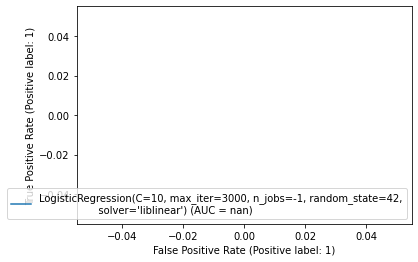

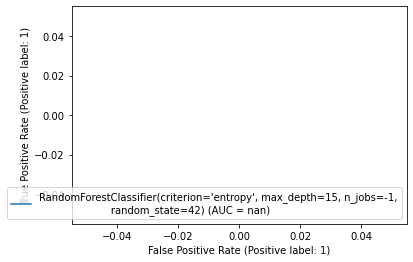

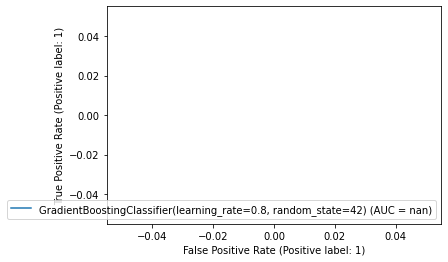

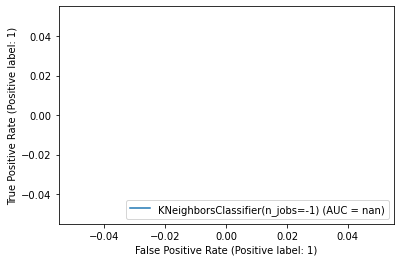

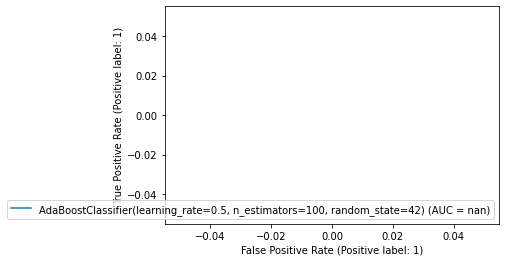

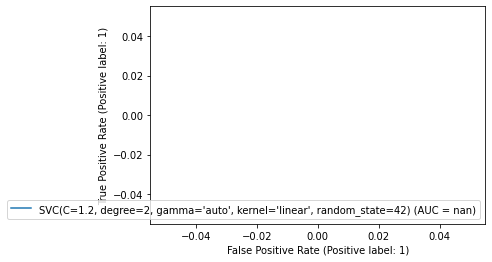

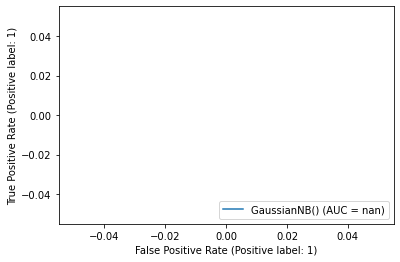

In [39]:
clf_logreg_gear, pred_logreg_gear = logreg(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_rfc_gear, pred_rfc_gear = rfc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_gbc_gear, pred_gbc_gear = gbc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_knn_gear, pred_knn_gear = knn(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_abc_gear, pred_abc_gear = abc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_svc_gear, pred_svc_gear = svc(X_train_gear, X_test_gear, y_train_gear, y_test_gear)
clf_gnb_gear, pred_gnb_gear = gnb(X_train_gear, X_test_gear, y_train_gear, y_test_gear)